# Topological Porosity Analysis Example Process

First load in a couple of images. 
You should see the first three (left) example images have 20 'pores' and the three on the right have 60 'pores'.

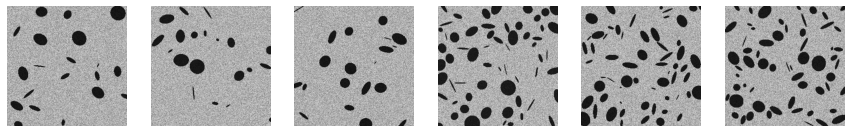

In [45]:
import os, sys
from tqdm import tqdm 
import numpy as np
import pandas as pd
from PIL import Image
from skimage.filters import threshold_otsu
import homcloud.interface as hc
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import seaborn as sns
import logging
logger = logging.getLogger("example")
rcParams.update({'font.size': 12})

src_path = os.path.realpath('./../../../src')
sys.path.append(src_path)

import utils 
import preprocessing_images as preprocess
import persistent_homology_SEDT as ph
import persistence_statistics_per_quadrant as stats
import plots as plots

path=os.getcwd()+'/'
filenames = [
    "example_ellipses_20_1.tif",
    "example_ellipses_20_2.tif",
    "example_ellipses_20_3.tif",
    "example_ellipses_60_1.tif",
    "example_ellipses_60_2.tif",
    "example_ellipses_60_3.tif"
    ]

images=[]
for i in range(len(filenames)):
    images.append(np.array(Image.open(path+filenames[i])))

#plot the images
fig,ax = plt.subplots(1,6, figsize=(15,10))
for i in range(6):
    ax[i].imshow(images[i], cmap="Greys_r")
    ax[i].axis('off')
    ax[i].axis('off')
plt.show()

Next we want to threshold each image to binary. Here we use Ostu's thresholding technique.

Thresholds: [89.4389, 91.04787, 90.539795, 88.40241, 88.22197, 88.18486]


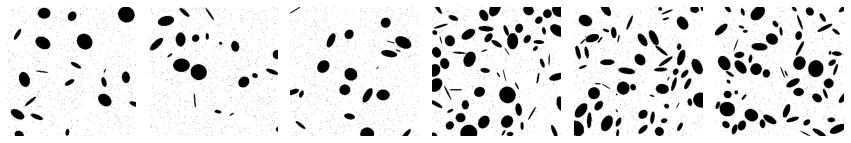

In [46]:
binary_images = []
thresholds = []
for image in images:
    val = threshold_otsu(image)
    thresholds.append(val)
    binary_im = (image > val).astype(int)
    binary_images.append(binary_im)

print(f"Thresholds: {thresholds}")

#plot the images
fig,ax = plt.subplots(1,6,gridspec_kw = {'wspace':0.1, 'hspace':0.1}, figsize=(15,10))
for i in range(6):
    ax[i].imshow(binary_images[i], cmap="binary_r")
    ax[i].axis('off')
plt.show()

Normally, we'd trim redundant background rows and columns off the binary images. 
Because these images don't have background, we include the code and nothing gets trimmed.

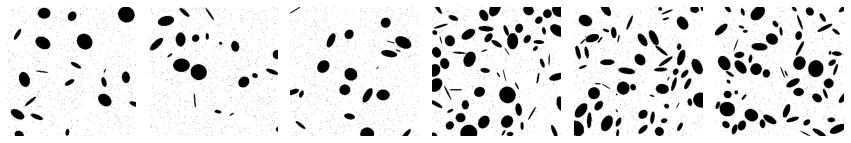

In [47]:
# trim the images of border rows full of 0s (edge_val)
trimmed_binary_images = []
for binary_image in binary_images:
    trimmed_binary_images.append(preprocess.trim(binary_image, edge_val=0))


#plot the images
fig,ax = plt.subplots(1,6,gridspec_kw = {'wspace':0.1, 'hspace':0.1}, figsize=(15,10))
for i in range(6):
    ax[i].imshow(trimmed_binary_images[i], cmap="binary_r")
    ax[i].axis('off')
plt.show()


Next we want to take non overlapping patches of each image, 
here we're going to take 100 x 100 pixels square patches.
This requires us to pad the images to integer mutliples of the patch shape,
 so that all patches are the same size. We can also discard all patches that
  are entirely background (all 0s) for both images, which in this case is none.


In [48]:
# pad the binary images and cut into 100 x 100 pixels patches
patch_shape = 100
pad_val = 0
background_val = 0 

padded_images = []
patches_per_image = []
patch_coords = []
padded_shape = []

for image in trimmed_binary_images:
    # extracts square patches size patch_size x patch_size stride apart
    padded_image, patches, coords = preprocess.extract_patches(
        image,
        patch_shape,
        pad_val=pad_val,
        stride=100)
    padded_images.append(padded_image)
    padded_shape.append(padded_image.shape)

    patches_to_keep = []
    patch_coords_to_keep = []
    patches_discarded = 0
    for j in range(len(patches)):
        patch = patches[j]
        coord = coords[j]
        # how much of the patch is background?
        patch_background_percentage = np.sum(patch <= background_val)/(patch_shape*patch_shape)
        # keep patch if it's not entirely background
        if  (patch_background_percentage < 1.0):
            patches_to_keep.append(patch)
            patch_coords_to_keep.append(coord)

    patches_per_image.append(patches_to_keep)
    patch_coords.append(patch_coords_to_keep)


We can plot the patches for one of the images (last one).
Alter s between [0,5] below to show the other images.

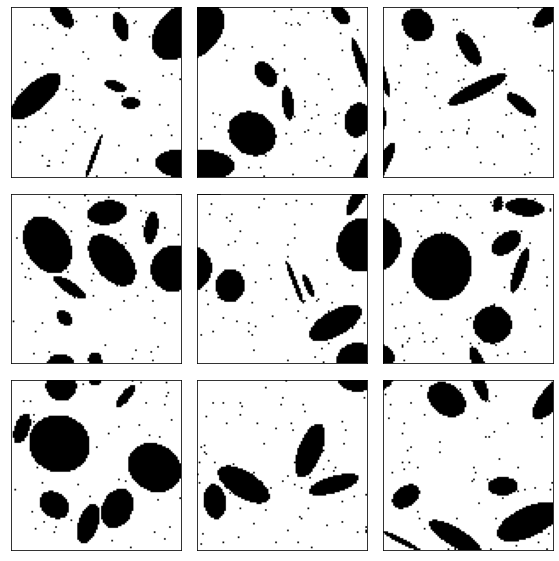

In [49]:
s=5

# plot the binary patches for the last image
rows = int(padded_shape[s][0]/patch_shape)
cols = int(padded_shape[s][1]/patch_shape)

fig, ax = plt.subplots(rows,cols,gridspec_kw = {'wspace':0., 'hspace':0.1}, figsize=(10,10))
for k in range(rows*cols):
    i = int(patch_coords[s][k][0]/patch_shape)
    j = int(patch_coords[s][k][1]/patch_shape)
    ax[i,j].imshow(patches_per_image[s][k], cmap="binary_r")
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

Perform a signed Euclidean distance transform per patch

In [50]:
SEDT_patches_per_image = []
for patches in patches_per_image:
    SEDT_patches = []
    for j in range(len(patches)):
        SEDT_patch = preprocess.SEDT(patches[j])
        SEDT_patches.append(SEDT_patch)
    SEDT_patches_per_image.append(SEDT_patches)


Let's plot the signed Euclidean distance transform of some patches.
To do the same for other images, set s to an integer in [0,5]

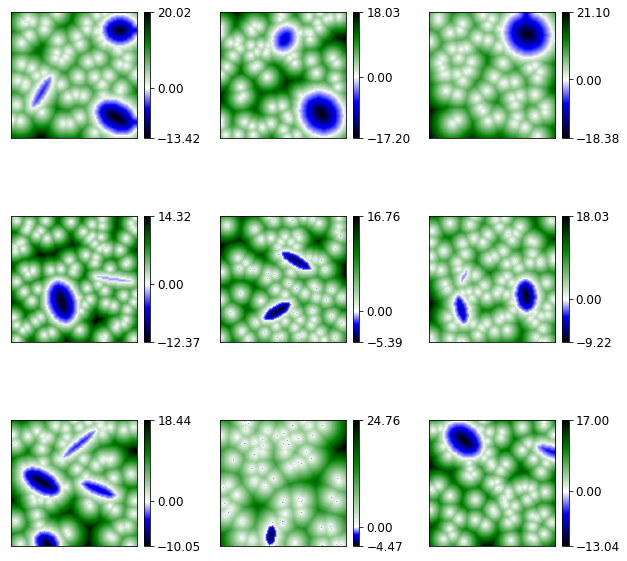

In [51]:
# get the SEDT patches for image s
s= 0

# make custom colourmap, set zero as midpoint
specific_colors = LinearSegmentedColormap.from_list('name',
    [(0,'k'),(0.3,'b'),(0.5,'w'),(0.8,'g'),(1,'k')],N=1000)

fig, ax = plt.subplots(rows,cols,gridspec_kw = {'wspace':0.5, 'hspace':0.5}, figsize=(10,10))
for k in range(rows*cols):
    i = int(patch_coords[s][k][0]/patch_shape)
    j = int(patch_coords[s][k][1]/patch_shape)
    SEDT_patch = SEDT_patches_per_image[s][k]
    vmin, vcenter, vmax = np.min(SEDT_patch), 0, np.max(SEDT_patch)
    divnorm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax) 
    im = ax[i,j].imshow(SEDT_patch, cmap=specific_colors, norm=divnorm)
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)
    divider = make_axes_locatable(ax[i,j])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(im, cax=cax,orientation='vertical', ticks=[vmin,0,vmax])


Calculate the persistent homology for all the patches, using the signed Euclidean distance transform.
This process produces .idiagram files, which will need to be saved out and 
csv files of the persistence diagrams as birth death intervals,
 for H0 and H1 respectively.

In [52]:
# calculate sublevel set cubical homology persistence for each image

idiagram_path= path+'idiagrams/'
utils.directory(idiagram_path)
interval_path = path+'persistence_intervals/'
utils.directory(interval_path)
for i in range(6):
    SEDT_patches = SEDT_patches_per_image[i]
    for j in tqdm(range(len(SEDT_patches))):
        SEDT_patch = SEDT_patches[j]
        name = f"{filenames[i][:-4]}_patch_{j}SEDT"
        ph.peristent_homology_sublevel_cubic(
            SEDT_patch,
            name,
            path,
            plot_persistence_diagrams=False)
        

100%|██████████| 9/9 [00:02<00:00,  4.49it/s]


Now we need to read all the persistence diagrams (interval) files.
Then calculate the statistics per quadrant for each persistence diagram.
Split radius can be set to count the number of pores with radius less than or
 greater than or equal to a specific value.
 It's faster to save out a statistics file per persistence diagram, then 
 combine into a single file.

In [53]:
interval_filenames = [file for file in os.listdir(interval_path)
                      if os.path.isfile(os.path.join(interval_path, file))]
interval_files = []
for name in interval_filenames:
    interval_files.append(
        pd.read_csv(
            interval_path+name,
            header=None,
            names=['birth','death']
            )
        )

stats_path = path+'stats/'
utils.directory(stats_path)

for j in range(len(interval_files)):
    dim = int(interval_filenames[j][7])
    stats.quadrant_statistics(
        interval_files[j],
        dim,
        interval_filenames[j],
        stats_path,
        split_radius=-2)

# combine all statistics files
stats_df = utils.combine_stats_files(
    stats_path,
    path,
    "all_statistics.csv",
    logger
    )    
# delete individual files & location
stats_files = [os.remove(stats_path+file) for file in os.listdir(stats_path)]
os.rmdir(stats_path)


Now that we've calculated the persistence statistics, lets look at some plots!
To compare, we'll group patches from the first three images with 20 pores 
together, and likewise for the patches from images with 60 pores.
Also, we'll look at a specific subset of the statistic, as specified in 
feature_cols.

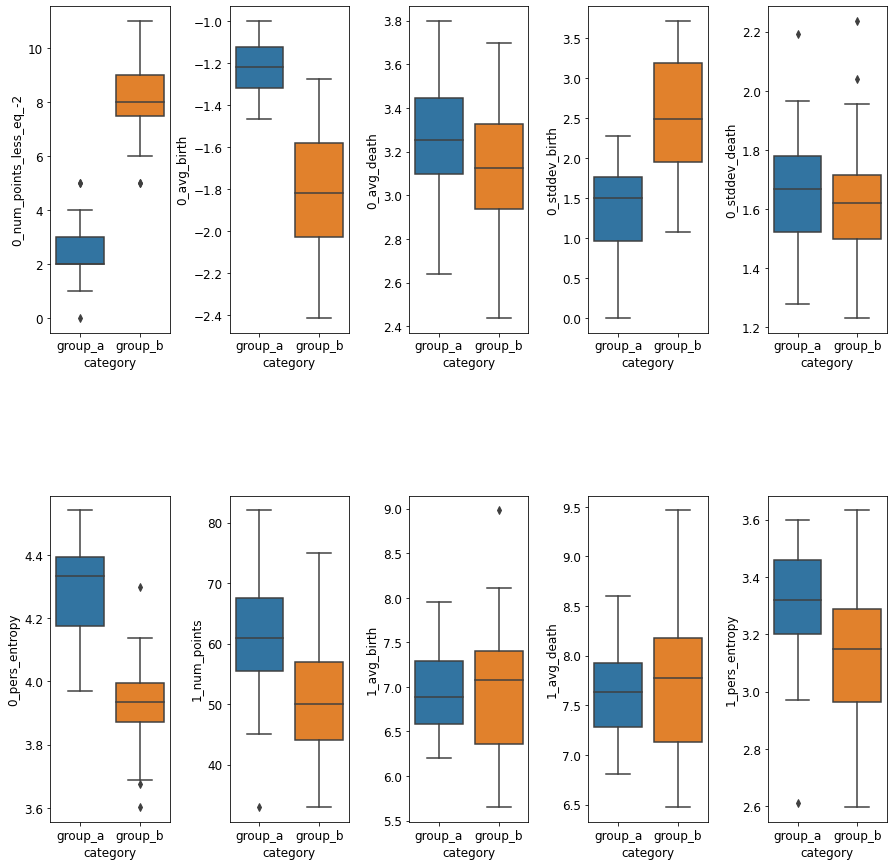

In [54]:
# read in full statistics dataframe
stats_df = pd.read_csv(path+'all_statistics.csv', index_col=0)

plot_path = path+'plots/'
utils.directory(plot_path)

filenames_map = {
    "example_ellipses_20_1.tif":"group_a",
    "example_ellipses_20_2.tif":"group_a",
    "example_ellipses_20_3.tif":"group_a",
    "example_ellipses_60_1.tif":"group_b",
    "example_ellipses_60_2.tif":"group_b",
    "example_ellipses_60_3.tif":"group_b"
    }

feature_cols = [
    '0_num_points_less_eq_-2',
    '0_avg_birth',
    '0_avg_death',
    '0_stddev_birth',
    '0_stddev_death',
    '0_pers_entropy',
    '1_num_points',
    '1_avg_birth',
    '1_avg_death',
    '1_pers_entropy']
stats_df['filename'] = stats_df['filename'].apply(lambda x:x[:-10]+'.tif')

plots.analysis_plots(
    stats_df,
    filenames_map,
    plot_path,
    feature_cols)

for quadrant in [1,2]:
    utils.directory(f"{plot_path}Q{quadrant}")

# create category map from filenames dictionary
stats_df['category'] = stats_df['filename'].map(filenames_map)

fig,ax = plt.subplots(2,5, gridspec_kw = {'wspace':0.5, 'hspace':0.5}, figsize=(15,15))
for k in range(10):
    if k<5:
        row,cols=0,k
    else:
        row,cols=1,k-5
    for quadrant in [1,2]:
        stats_quad = stats_df.loc[stats_df['quadrant']==quadrant]
        col = feature_cols[k]
        single_stat = stats_quad[['category', col]]
        single_stat = single_stat.dropna()
        if single_stat.shape[0] >= 2:
            sns.boxplot(ax=ax[row,cols], x='category', y=col, data=single_stat, dodge=True)
plt.show()



We can visualise the statistics per patch back on the entire image:

C:\Apps\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Apps\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Apps\Anaconda3\lib\site-packages\pandas\core\indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


(-0.5, 1079.5, 935.5, -0.5)

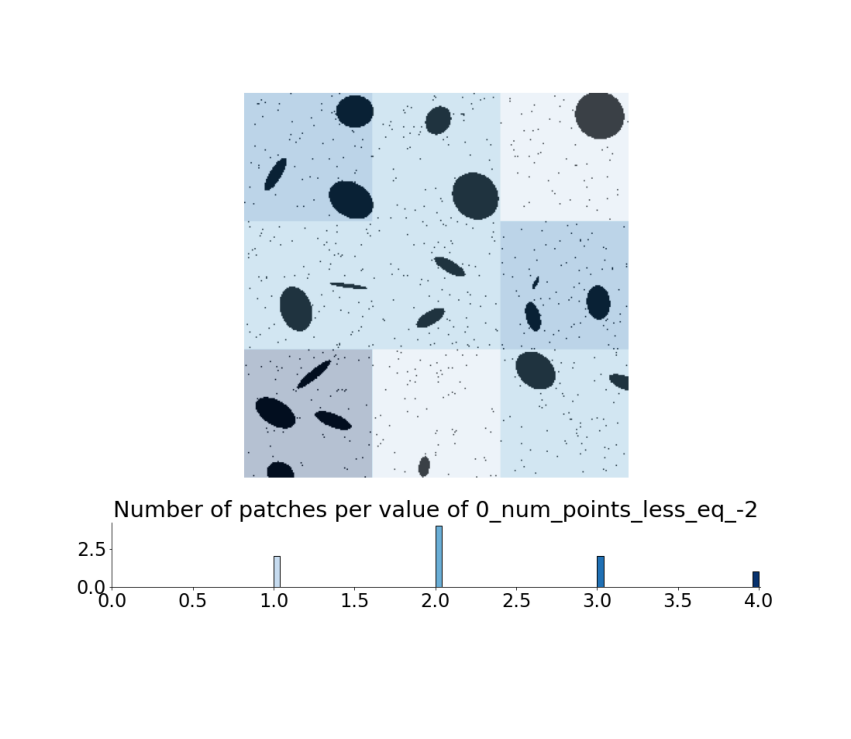

In [55]:
import visualise_patch_scores as vis
utils.directory(path+'visualise/')
stats_df = pd.read_csv(path+'all_statistics.csv', index_col=0)
stats_df = stats_df[stats_df['quadrant']==2]

scores = stats_df[['filename', 'patch_number','0_num_points_less_eq_-2']]
coords_row_map = dict(zip(range(9), [i[0] for i in coords]))
coords_col_map = dict(zip(range(9), [i[1] for i in coords]))
scores['filename'] = scores['filename'].apply(lambda x: x[:-10]+'.tif')
scores.loc[:,'coord_array_row'] = scores['patch_number'].map(coords_row_map)
scores.loc[:,'coord_array_col'] = scores['patch_number'].map(coords_col_map)
scores.loc[:,'image_shape_x'] = 300
scores.loc[:,'image_shape_y'] = 300
scores.loc[:,'patch_width'] = 100
scores.loc[:,'patch_height'] = 100
scores = scores.dropna(subset=['0_num_points_less_eq_-2'])

vis.plot_patch_scores(
    trimmed_binary_images[0],
    filenames[0],
    scores,
    path+'visualise/',
    logger,
    colour='Blues',
    normalise_scores='no',
    alpha=0.3,
    score_column='0_num_points_less_eq_-2'
)
vis_plot = Image.open(f"{path}visualise/{filenames[0][:-4]}_0_num_points_less_eq_-2_Blues.png")
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.imshow(vis_plot)
plt.axis('off')

These persistence statistcs (and many others that we can calculate) can be used
for classification with a support vector machine.

Below, we demonstrate how to run the entire process, using the main function
in run_process.py. Results save in example folder in current date/time folder
for each run.

In [57]:
path=os.getcwd()+'/'
feature_cols = [
    '0_num_points',
    '0_num_points_less_eq_-2',
    '0_avg_birth',
    '0_stddev_birth',
    '0_skew_birth',
    '0_percentile_25_birth',
    '0_percentile_75_birth',
    '0_iqr_birth',
    '0_avg_death',
    '0_stddev_death',
    '0_skew_death',
    '0_percentile_25_death',
    '0_percentile_75_death',
    '0_iqr_death',
    '0_pers_entropy',
    '1_num_points',
    '1_avg_birth',
    '1_stddev_birth',
    '1_skew_birth',
    '1_percentile_25_birth',
    '1_percentile_75_birth',
    '1_iqr_birth',
    '1_avg_death',
    '1_stddev_death',
    '1_skew_death',
    '1_percentile_25_death',
    '1_percentile_75_death',
    '1_iqr_death',
    '1_pers_entropy']
filenames_map = {
    "example_ellipses_20_1.tif":"group_a",
    "example_ellipses_20_2.tif":"group_a",
    "example_ellipses_20_3.tif":"group_a",
    "example_ellipses_60_1.tif":"group_b",
    "example_ellipses_60_2.tif":"group_b",
    "example_ellipses_60_3.tif":"group_b"
    }
import run_process as run_process
stats_df, results = run_process.topological_porosity_analysis(
    path,
    logger,
    preprocess.otsu_threshold,
    patch_shape=100,
    stride=100,
    save_persistence_diagrams=False,
    analysis_plots=True,
    classification=True,
    feature_cols=feature_cols,
    filenames_map=filenames_map,
    runs=10,
    strat_col=None,
    cross_val='stratkfold',
    param_grid_SVC = {'C': [1,2,3], 'kernel': ('rbf','linear')}
)

Files dropped incorrect extensions: ['all_statistics.csv', 'example.ipynb']
runs: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]
